# Index-1 DAE (1 differential, 1 algebraic) and reduced ODE in y

This teaching-style notebook walks through the problem, the reduction to an ODE, and a comparison between:
- A direct DAE solve using a mass matrix and RadauDAE
- A reduced ODE in $y$ using the algebraic constraint $z=\cos^2(y)$

Reference: Lawder, M. T., Ramadesigan, V., Suthar, B., & Subramanian, V. R. (2015).  
**Extending explicit and linearly implicit ODE solvers for index-1 DAEs.**  
Computers & Chemical Engineering, 82, 283–292.  
https://doi.org/10.1016/j.compchemeng.2015.06.012

## 1) Model and initial conditions

We are given the index-1 DAE:
$$
\frac{dy(t)}{dt} = -y(t)^2 + z(t) \tag{1}
$$
$$
\cos(y(t)) - \sqrt{z(t)} = 0 \tag{2}
$$

- $y(t)$ is the differential variable, $z(t)$ is the algebraic variable.
- Consistent initial conditions:
  - $y(0) = 0.25$
  - $z(0) = \cos^2(0.25)$

**Reduced ODE**

From the algebraic constraint $ \cos(y) - \sqrt{z} = 0 $, we get:
$$
z(t) = \cos^2(y(t)).
$$

Substituting into (1) gives the reduced ODE in $y$:
$$
\frac{dy}{dt} = -y^2 + \cos^2(y).
$$

We will use $y(0) = 0.25$ for both the DAE and the reduced ODE (per the reference).

---

## 2) DAE formulation (mass matrix form)

We write the system as $M \dot{x} = f(x)$ with $x = [y, z]^T$:
$$
M = \begin{bmatrix} 1 & 0 \\ 0 & 0 \end{bmatrix}, \quad
f(x) = \begin{bmatrix} -y^2 + z \\ \cos(y) - \sqrt{z} \end{bmatrix}.
$$

- The first row is differential (for $y$).
- The second row is algebraic (for $z$).

---

## 3) Define functions (short, interleaved code blocks with explanations)

Below, each function has a concise docstring, so students can re-use them later.

In [1]:
import numpy as np

In [13]:
def fun_dae(t, x):
    """
    DAE right-hand side for the index-1 system.

    Parameters
    ----------
    t : float
        Current time.
    x : ndarray (2,)
        State vector [y, z].

    Returns
    -------
    f : ndarray (2,)
        Residuals f(x):
        f[0] = -y^2 + z            (differential equation)
        f[1] = cos(y) - sqrt(z)    (algebraic constraint)
    """
    y, z = x
    return np.array([
        -y**2 + z,
        np.cos(y) - np.sqrt(z)
    ])

The Jacobian helps the implicit solver converge efficiently (Newton iterations + LU factorization):

In [14]:
def jac_dae(t, x):
    """
    Jacobian of f with respect to [y, z].

    J = [ [-2*y,     1            ],
          [ -sin(y), -1/(2*sqrt(z)) ] ]

    Parameters
    ----------
    t : float
        Current time.
    x : ndarray (2,)
        State vector [y, z].

    Returns
    -------
    J : ndarray (2,2)
        Jacobian matrix.
    """
    y, z = x
    return np.array([
        [-2.0*y, 1.0],
        [-np.sin(y), -0.5/np.sqrt(z)]
    ])


Mass matrix and variable index specify the DAE structure:

In [15]:
# Mass matrix: y is differential, z is algebraic
mass = np.array([[1.0, 0.0],
                 [0.0, 0.0]])

# Variable index: 0 = differential, 1 = algebraic
var_index = np.array([0, 1])


Set consistent initial conditions:

In [16]:
y0 = 0.25
z0 = np.cos(y0)**2
x0 = np.array([y0, z0])


The reduced ODE eliminates $z=cos^2(y)$

In [17]:
def fun_reduced(t, y):
    """
    Reduced ODE in y only, using z = cos^2(y).

    dy/dt = -y^2 + cos^2(y)

    Parameters
    ----------
    t : float
        Current time.
    y : float
        Differential variable.

    Returns
    -------
    dydt : float
        Time derivative of y.
    """
    return -y**2 + np.cos(y)**2


## 4) Solve both problems and compare (timing + stats + plots)
We solve the DAE with RadauDAE (mass matrix) and the reduced ODE with a stiff-friendly implicit ODE solver. Then, we compare solution of DAE solver with robust SciPy ODE solver.

In [18]:
import time
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from radauDAE import RadauDAE

In [19]:
# Time horizon and sampling
t_span = (0.0, 4.0)
t_eval = np.linspace(t_span[0], t_span[1], 400)

In [20]:
# --- DAE solve ---
t_start = time.time()
sol_dae = solve_ivp(fun=fun_dae, t_span=t_span, y0=x0,
                    method=RadauDAE,
                    mass_matrix=mass,
                    var_index=var_index,
                    jac=jac_dae,
                    rtol=1e-8, atol=1e-10,
                    t_eval=t_eval,
                    dense_output=True)
t_end = time.time()
runtime_dae = t_end - t_start

print(f"[DAE] Finished in {runtime_dae:.6f} s, steps={sol_dae.t.size-1}, success={sol_dae.success}")
print(f"[DAE] nfev={sol_dae.nfev}, njev={sol_dae.njev}, nlu={sol_dae.nlu}")

[DAE] Finished in 0.132661 s, steps=399, success=True
[DAE] nfev=937, njev=39, nlu=53


In [21]:
# --- Reduced ODE solve (in y only) ---
t_start = time.time()
sol_ode = solve_ivp(fun=fun_reduced, t_span=t_span, y0=[y0],
                    method='Radau',           # implicit, stiff-friendly ODE solver
                    rtol=1e-8, atol=1e-10,
                    t_eval=t_eval,
                    dense_output=True)
t_end = time.time()
runtime_ode = t_end - t_start

print(f"[ODE] Finished in {runtime_ode:.6f} s, steps={sol_ode.t.size-1}, success={sol_ode.success}")
print(f"[ODE] nfev={sol_ode.nfev}, njev={sol_ode.njev}, nlu={sol_ode.nlu}")

[ODE] Finished in 0.098320 s, steps=399, success=True
[ODE] nfev=798, njev=3, nlu=38


In [22]:
# Extract solutions
y_dae = sol_dae.y[0]
z_dae = sol_dae.y[1]
y_ode = sol_ode.y[0]
z_ode = np.cos(y_ode)**2

# Error metrics (infinity norm)
err_y = np.linalg.norm(y_dae - y_ode, ord=np.inf)
err_z = np.linalg.norm(z_dae - z_ode, ord=np.inf)
print(f"Max-norm error in y: {err_y:.3e}")
print(f"Max-norm error in z: {err_z:.3e}")

Max-norm error in y: 1.128e-09
Max-norm error in z: 5.158e-09


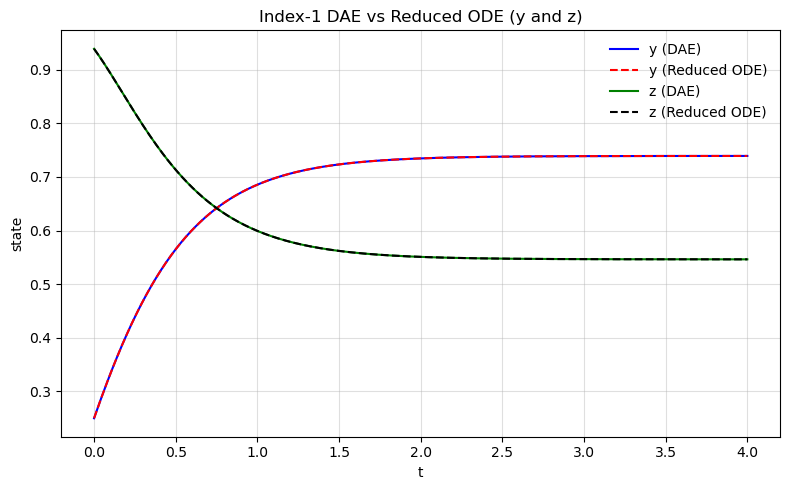

In [23]:
# Plot
plt.figure(figsize=(8,5))
plt.plot(t_eval, y_dae, 'b-',  label='y (DAE)')
plt.plot(t_eval, y_ode, 'r--', label='y (Reduced ODE)')
plt.plot(t_eval, z_dae, 'g-',  label='z (DAE)')
plt.plot(t_eval, z_ode, 'k--', label='z (Reduced ODE)')
plt.xlabel('t')
plt.ylabel('state')
plt.title('Index-1 DAE vs Reduced ODE (y and z)')
plt.legend(frameon=False)
plt.grid(True, alpha=0.4)
plt.tight_layout()
plt.show()

## 5) What students should notice

* The algebraic constraint $z=cos^2(y)$ makes the system index-1: 𝑧 is defined directly by 𝑦 at all times.

* The reduced ODE in 𝑦 uses the constraint to eliminate the algebraic variable. It is nonlinear and generally requires implicit methods for robustness.

* With consistent ICs, the DAE and reduced ODE solutions agree to tight tolerances, and the max-norm error is very small (often $≈10^{−10}$ given the tolerances).

* Solver statistics (function/Jacobian evaluations and LU decompositions) reveal the inner workings (Newton iterations and linear solves) of implicit methods.